In [ ]:
!pip install easycolab
import easycolab as ec
ec.mount()

  Created wheel for easycolab: filename=easycolab-0.1b29-py3-none-any.whl size=4471 sha256=6d2315993b373b4f0dcc7169fe95c5a36dfd142270b2e6c6e932a086c1090d11
  Stored in directory: /root/.cache/pip/wheels/66/70/70/3b22a234ffaaec549fa821c9c8e0f8900b41d6a59f06a70d03
Successfully built easycolab
Mounted at /content/gdrive
Opening directory /content/gdrive/My Drive/
Done!


In [ ]:
!wget --no-check-certificate http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
! mkdir facades/train/0 && mv facades/train/*.jpg facades/train/0
! mkdir facades/val/0 && mv facades/val/*.jpg facades/val/0
! mkdir facades/test/0 && mv facades/test/*.jpg facades/test/0

--2021-12-13 12:35:03--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.7’

facades.tar.gz.7    100%[===================>]  28.77M  2.91MB/s    in 8.4s    

2021-12-13 12:35:12 (3.44 MB/s) - ‘facades.tar.gz.7’ saved [30168306/30168306]

mkdir: cannot create directory ‘facades/train/0’: File exists
mkdir: cannot create directory ‘facades/val/0’: File exists
mkdir: cannot create directory ‘facades/test/0’: File exists


In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import cv2 as cv
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import os

In [ ]:
path = './facades'

In [ ]:
img = cv.imread('./facades/train/0/110.jpg')

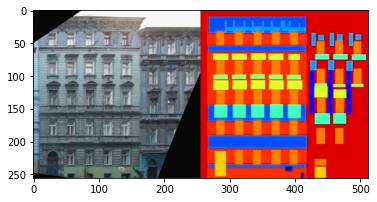

In [ ]:
plt.imshow(img)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
image_size = 256
batch_size = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
class PhotoMapDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        photo_image, map_image = torch.chunk(sample, chunks=2, dim=2)
        return photo_image, map_image

In [ ]:
train_dataset = PhotoMapDataset(root=os.path.join(path, "train"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
val_dataset = PhotoMapDataset(root=os.path.join(path, "val"), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#test_dataset = PhotoMapDataset(root=os.path.join(path, "test"), transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class ConvDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(),
            )
        
    def forward(self, x):
        out = self.convs(x)
        return out

In [ ]:
class ConvUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super().__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
        self.activ = nn.ReLU()
        self.norm = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        x = self.deconv(x)
        x = self.norm(x)
        out = self.activ(x)        
        return out

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super().__init__()

        self.convs = nn.Sequential(nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                                   nn.InstanceNorm2d(out_channels),
                                   nn.ReLU(),
                                   nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        )
        

    def forward(self, x):
        out = self.convs(x) + x        
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        self.padding = nn.ReflectionPad2d(3)
        self.blocks = nn.ModuleList([
            ConvDownBlock(3, n_base_channels * 1, kernel_size=7, stride=1, padding=0),
            ConvDownBlock(n_base_channels * 1, n_base_channels * 2),
            ConvDownBlock(n_base_channels * 2, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ResNetBlock(n_base_channels * 4, n_base_channels * 4),
            ConvUpBlock(n_base_channels * 4, n_base_channels * 2),
            ConvUpBlock(n_base_channels * 2, n_base_channels * 1),                           
        ])
        self.final_block = nn.Sequential(nn.ReflectionPad2d(3),
                                         nn.Conv2d(n_base_channels * 1, 3, kernel_size=7, stride=1),
                                         nn.Tanh()
        )
    def forward(self, x):
        x = self.padding(x)
        for i, block in enumerate(self.blocks):
            x = block(x)
        out = self.final_block(x)
        return out

In [ ]:
class DiscrBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, strides, padding, isnorm=False):
      super().__init__()
      if isnorm:
          self.convs = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.InstanceNorm2d(out_channels),
              nn.LeakyReLU(0.2)
          )
      else:
          self.convs = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.LeakyReLU(0.2)
          )
  def forward(self, x):
      out = self.convs(x)
      return out



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, n_base_channels=64, kernel_size=4, strides=2, padding=1):
        super().__init__()
        self.blocks = nn.ModuleList([
            DiscrBlock(in_channels, n_base_channels, kernel_size, strides, padding),
            DiscrBlock(n_base_channels * 1, n_base_channels * 2, kernel_size, strides, padding, isnorm=True),
            DiscrBlock(n_base_channels * 2, n_base_channels * 4, kernel_size, strides, 1, isnorm=True),
            DiscrBlock(n_base_channels * 4, n_base_channels * 8, kernel_size, strides//2 , 1, isnorm=True),
            DiscrBlock(n_base_channels * 8, 1, kernel_size, strides//2, 0)
        ])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for i, block in enumerate(self.blocks):
            x = block(x)
        out = self.sigmoid(x)
        return out

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
generator1 = Generator(n_base_channels=64).to(device)
discriminator1 = Discriminator().to(device)

generator2 = Generator(n_base_channels=64).to(device)
discriminator2 = Discriminator().to(device)

In [ ]:
generator1.apply(weights_init)
discriminator1.apply(weights_init)

generator2.apply(weights_init)
discriminator2.apply(weights_init)

Discriminator(
  (blocks): ModuleList(
    (0): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_ru

In [ ]:
gen1_opt = torch.optim.Adam(generator1.parameters(), lr=2e-4, betas=(0.5, 0.999))
gen2_opt = torch.optim.Adam(generator2.parameters(), lr=2e-4, betas=(0.5, 0.999))

dis1_opt = torch.optim.Adam(discriminator1.parameters(), lr=2e-4, betas=(0.5, 0.999))
dis2_opt = torch.optim.Adam(discriminator2.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
def discriminator_loss(discriminator,x_real, x_fake):
    real_preds = discriminator(x_real)
    fake_preds = discriminator(x_fake)
    loss_D = criterion(real_preds, torch.ones_like(real_preds)) + criterion(fake_preds, torch.zeros_like(fake_preds))
    return loss_D / 2

def generator_loss(fake_preds):
    return criterion(fake_preds, torch.ones_like(fake_preds))


In [ ]:
def train_dis(discriminator, generator,x_real, dis_opt):
    x_fake=generator(z)
    dis_opt.zero_grad()
    loss_D = discriminator_loss(discriminator, x_real, x_fake)
    loss_D.backward()
    dis_opt.step()
    return loss_D.item()

def train_gen(discriminator1, discriminator2, generator1, generator2, x, z):
    x_fake=generator1(z)
    x_rec=generator2(x_fake)

    z_fake=generator2(x)
    z_rec=generator1(z_fake)

    gen1_opt.zero_grad()
    gen2_opt.zero_grad()

    x_fake_preds=discriminator1(x_fake)
    z_fake_preds=discriminator2(z_fake)


    loss_G = generator_loss(x_fake_preds) + generator_loss(z_fake_preds)

    
    loss_reconstr = 5*criterion_reconstr(x,x_rec) + 5*criterion_reconstr(z,z_rec) + 10*criterion_reconstr(generator2(z), z) + 10*criterion_reconstr(generator1(x), x)#.mean()
    loss_G += loss_reconstr
    loss_G.backward()
    gen1_opt.step()
    gen2_opt.step()
    return loss_G.item()

In [ ]:
generator1.load_state_dict(torch.load('./hw3_dl/cyclegan_generator1.pth'), strict=False)
discriminator1.load_state_dict(torch.load('./hw3_dl/cyclegan_discriminator1.pth'), strict=False)
generator2.load_state_dict(torch.load('./hw3_dl/cyclegan_generator2.pth'), strict=False)
discriminator2.load_state_dict(torch.load('./hw3_dl/cyclegan_discriminator2.pth'), strict=False)

<All keys matched successfully>

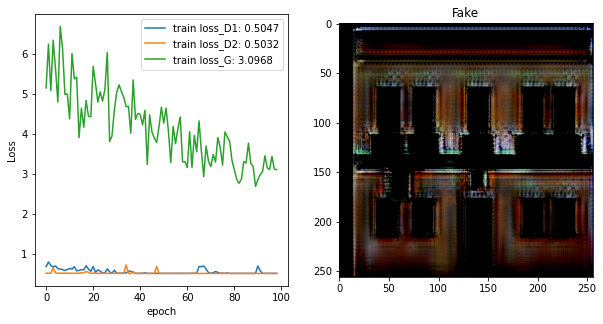

In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
criterion = nn.BCEWithLogitsLoss()
criterion_reconstr = nn.L1Loss()
losses_D1_hist = []
losses_G_hist = []
losses_D2_hist = []
for epoch in range(1, 100):
    generator1.train(True)
    discriminator1.train(True)
    generator2.train(True)
    discriminator2.train(True)
    for x,z in tqdm(train_loader):
        z=z.to(device)
        x=x.to(device)
        #z=Variable(z)

        for _ in range(1):
            loss_D1 = train_dis(discriminator1, generator1, x, dis1_opt)
            loss_D2 = train_dis(discriminator2, generator2, z, dis2_opt)
        loss_G = train_gen(discriminator1, discriminator2, generator1, generator2, x, z)

    losses_D1_hist.append(loss_D1)
    losses_G_hist.append(loss_G)
    losses_D2_hist.append(loss_D2)
    clear_output(True)
    generator1.eval()
    discriminator1.eval()
    generator2.eval()
    discriminator2.eval()

    with torch.no_grad():
        z=val_dataset[0][1]
        z=z.to(device).unsqueeze(0)
        #z=Variable(z)
        img=generator1(z)
        img=torch.clamp(img, min=0, max=1)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.plot(losses_D1_hist, label='train loss_D1: {:.4f}'.format(losses_D1_hist[-1]))
        plt.plot(losses_D2_hist, label='train loss_D2: {:.4f}'.format(losses_D2_hist[-1]))
        plt.plot(losses_G_hist, label='train loss_G: {:.4f}'.format(losses_G_hist[-1]))
        plt.legend()
        plt.subplot(1,2,2)
        plt.title("Fake")
        plt.imshow(img.cpu().detach().numpy().transpose([0, 2, 3, 1])[0])    
        plt.show()
    torch.save(generator1.state_dict(), './hw3_dl/cyclegan_generator1_v2.pth')
    torch.save(discriminator1.state_dict(), './hw3_dl/cyclegan_discriminator1_v2.pth')
    torch.save(generator2.state_dict(), './hw3_dl/cyclegan_generator2_v2.pth')
    torch.save(discriminator2.state_dict(), './hw3_dl/cyclegan_discriminator2_v2.pth')